In [4]:
pip install keras tensorflow sklearn pandas_datareader yfinance transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.3 MB/s eta 0:00:00


In [5]:
import pandas as pd
from transformers import pipeline

# Initialize sentiment analysis pipeline
nlp = pipeline("sentiment-analysis")

# Example texts
texts = [
    "The stock market is doing very well.",
    "The economic outlook for the next quarter is very bleak."
]

# Analyze sentiment
results = nlp(texts)

# Convert to DataFrame
df = pd.DataFrame(results)
print(df)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


      label     score
0  POSITIVE  0.999837
1  NEGATIVE  0.999706


In [8]:
pip install pandas yfinance keras tensorflow sklearn

In [13]:
import pandas as pd
import yfinance as yf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import load_model
import numpy as np
import os

# Define function to prepare data for LSTM model
def create_lstm_dataset(data, look_back=1):
    x_data, y_data = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        x_data.append(a)
        y_data.append(data[i + look_back, 0])
    return np.array(x_data), np.array(y_data)

# Define list of stocks
stocks = ['BLK', 'GS', 'JPM', 'DE']

# Create directory for storing models
os.makedirs('trained_models', exist_ok=True)

# Dictionaries to store trained models and data
trained_models = {}
scalers = {}
train_test_data = {}

# Loop over stocks
for stock in stocks:
    print(f"Processing stock: {stock}")

    # Load data
    try:
        data = yf.download(stock, start='2020-01-01', end='2022-12-31')
    except Exception as e:
        print(f"Error downloading data for stock {stock}: {str(e)}")
        continue

    # Preprocessing
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

    # Prepare LSTM training set
    look_back = 1
    x_data, y_data = create_lstm_dataset(scaled_data, look_back)

    # Split into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

    # Reshape input to be [samples, time steps, features]
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

    # Create LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train model
    try:
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        model_path = f'trained_models/{stock}_model.h5'
        model.save(model_path)  # Save the model to a file
        trained_models[stock] = model_path  # Store the model file path
        scalers[stock] = scaler  # Store the scaler
        train_test_data[stock] = (x_train, x_test, y_train, y_test)  # Store the train-test data
    except Exception as e:
        print(f"Error training model for stock {stock}: {str(e)}")

Processing stock: BLK
[*********************100%***********************]  1 of 1 completed
603/603 [==============================] - 6s 4ms/step - loss: 0.0239
Processing stock: GS
[*********************100%***********************]  1 of 1 completed
603/603 [==============================] - 4s 2ms/step - loss: 0.0239
Processing stock: JPM
[*********************100%***********************]  1 of 1 completed
603/603 [==============================] - 3s 2ms/step - loss: 0.0237
Processing stock: DE
[*********************100%***********************]  1 of 1 completed
603/603 [==============================] - 4s 2ms/step - loss: 0.0276


Evaluating model for stock: BLK
1/1 [==============================] - 0s 16ms/step
Mean Squared Error for BLK: 316246.6551899219


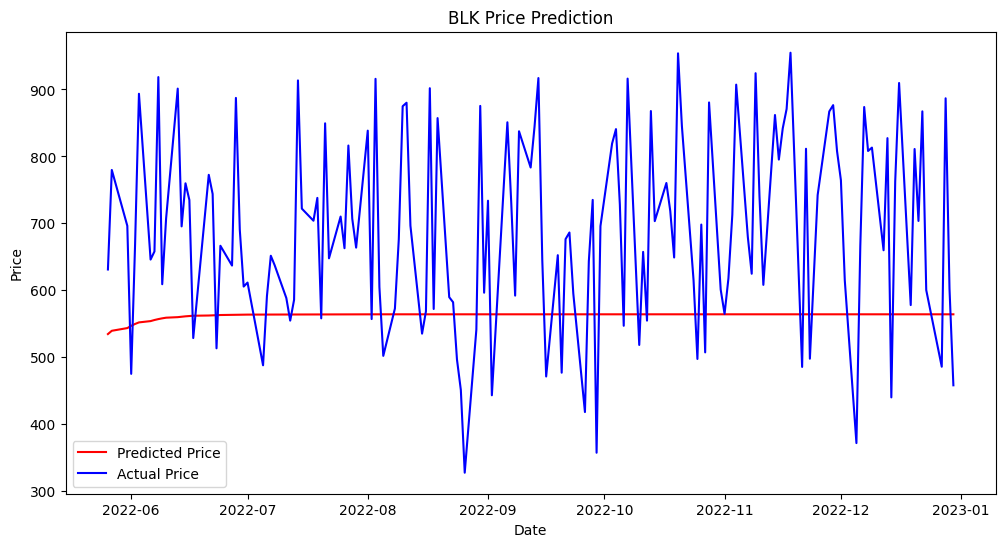

Evaluating model for stock: GS
1/1 [==============================] - 0s 15ms/step
Mean Squared Error for GS: 48320.37059081538


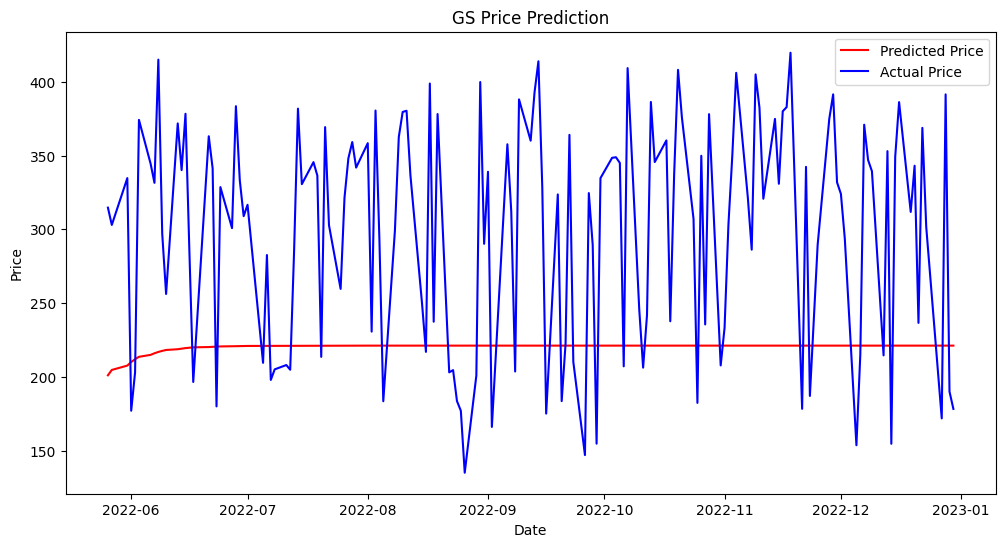

Evaluating model for stock: JPM
1/1 [==============================] - 0s 14ms/step
Mean Squared Error for JPM: 11631.337559803156


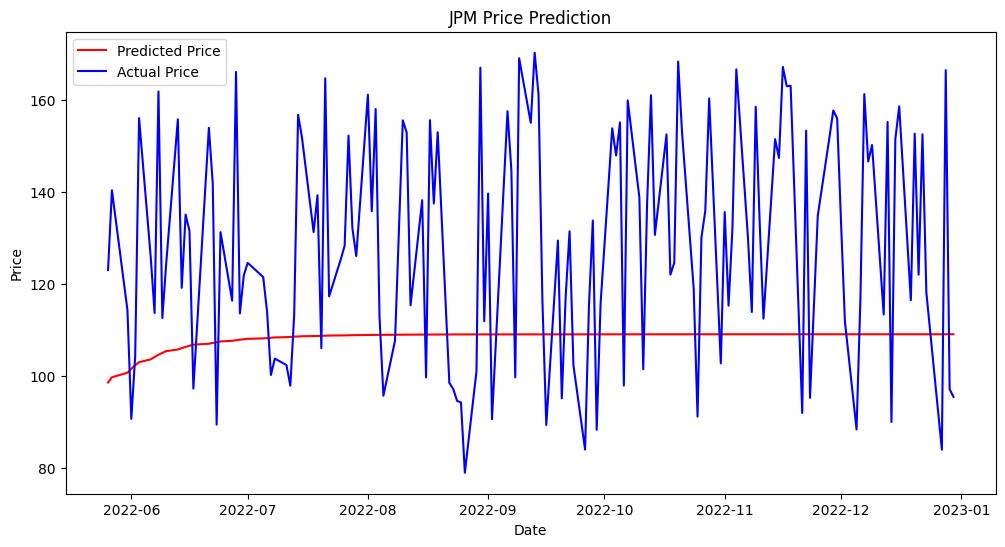

Evaluating model for stock: DE
1/1 [==============================] - 0s 20ms/step
Mean Squared Error for DE: 47633.82737399285


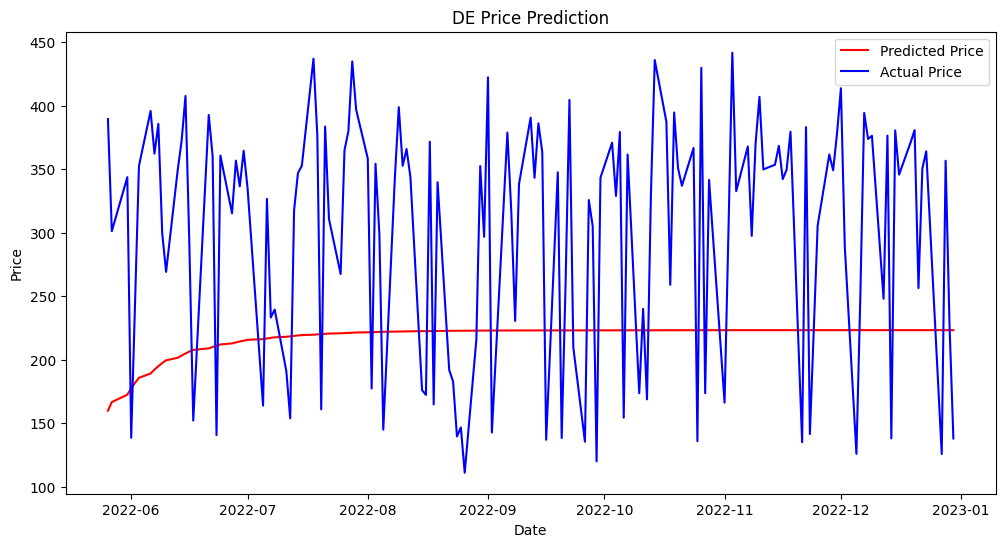

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Loop over stocks again to evaluate the models
for stock in stocks:
    print(f"Evaluating model for stock: {stock}")

    # Load the trained model from previous loop
    model = load_model(trained_models[stock])

    # Load the train-test data and scaler for the stock
    x_train, x_test, y_train, y_test = train_test_data[stock]
    scaler = scalers[stock]

    # Get the last element of the training set
    x_input = x_train[-1].reshape((1, 1, 1))

    # Create a list to hold the model's predictions
    predictions = []

    # Predict the closing price for the next day for each day in the test set
    for _ in range(len(x_test)):
        pred_price = model.predict(x_input)
        predictions.append(pred_price)

        # Update x_input to include the prediction and drop the oldest price
        x_input = np.append(x_input[:,1:,:], pred_price).reshape((1, 1, 1))

    # Reverse the scaling of the predictions
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Calculate mean squared error of the predictions
    mse = mean_squared_error(y_test, predictions)
    print(f"Mean Squared Error for {stock}: {mse}")

    # Plot the actual vs predicted prices
    plt.figure(figsize=(12,6))
    plt.plot(data.index[-len(x_test):], predictions, color='red', label='Predicted Price')
    plt.plot(data.index[-len(x_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Price')
    plt.title(f'{stock} Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [15]:
# Loop over stocks again to make future predictions
for stock in stocks:
    print(f"Predicting next day's closing price for stock: {stock}")

    # Load the trained model from previous loop
    model = load_model(trained_models[stock])

    # Load the train-test data and scaler for the stock
    x_train, x_test, y_train, y_test = train_test_data[stock]
    scaler = scalers[stock]

    # Get the last element of the entire dataset (train + test)
    x_input = np.concatenate((x_train, x_test))[-1].reshape((1, 1, 1))

    # Predict the next day's closing price
    pred_price = model.predict(x_input)

    # Reverse the scaling of the prediction
    pred_price = scaler.inverse_transform(pred_price)

    print(f"Predicted closing price for {stock} on next day: {pred_price[0][0]}")

Predicting next day's closing price for stock: BLK
1/1 [==============================] - 1s 821ms/step
Predicted closing price for BLK on next day: 473.6507263183594
Predicting next day's closing price for stock: GS
1/1 [==============================] - 1s 773ms/step
Predicted closing price for GS on next day: 187.31103515625
Predicting next day's closing price for stock: JPM
1/1 [==============================] - 1s 769ms/step
Predicted closing price for JPM on next day: 99.38155364990234
Predicting next day's closing price for stock: DE


1/1 [==============================] - 2s 2s/step
Predicted closing price for DE on next day: 149.6506805419922
